# Quantum Random Forest Model for Credit Card Fraud Detection

## Pre-processing the data

### Library Imports
I am using sci-kit learn for classical Random-Forest Model and utilities like train-test split, scaler & metrices

In [51]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

### Data Imports & Visualization
The Credit Card Fraud Detection Data is a highly imbalanced data with only 492 fraud cases and all other being non-fraud cases hence, we need to DownSample the data for uniformity to avoid bais learning

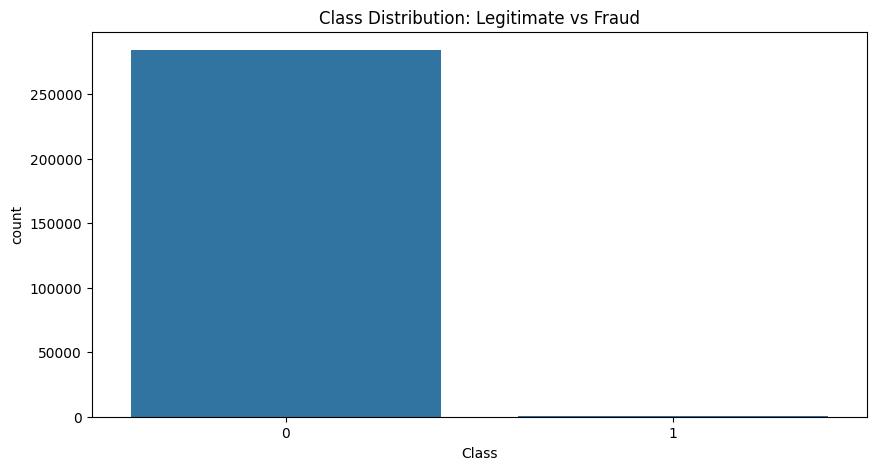

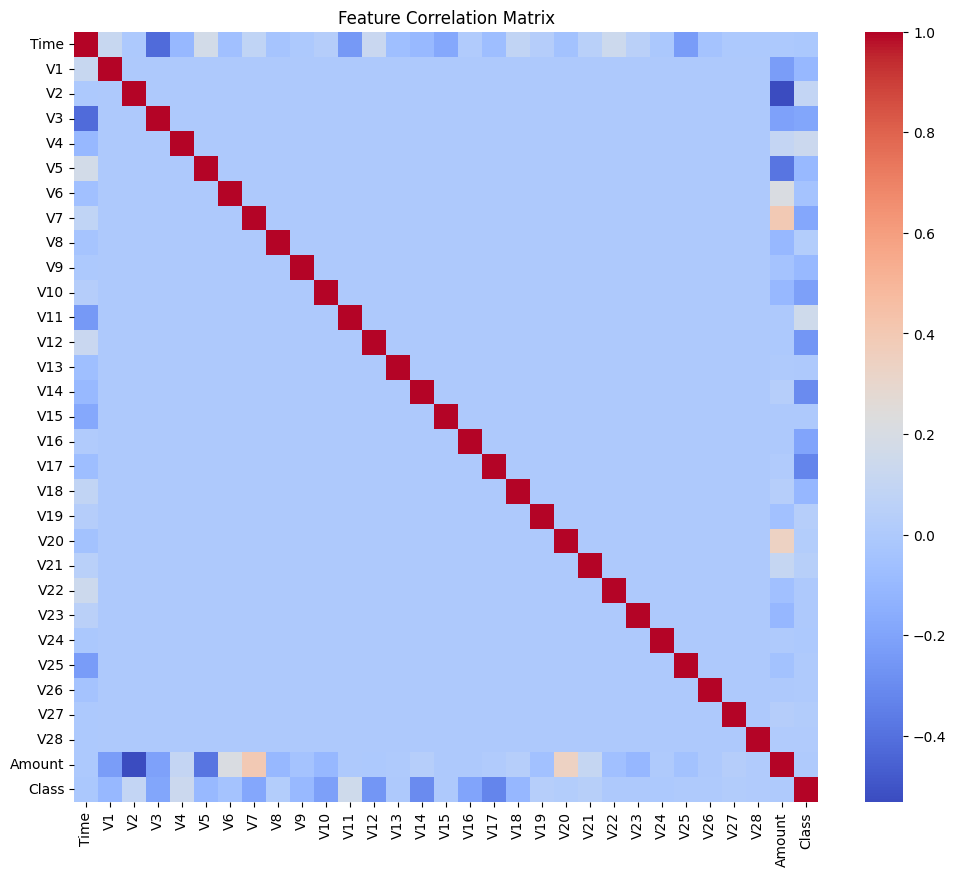

In [52]:
data = pd.read_csv('creditcard.csv')
plt.figure(figsize=(10, 5))
sns.countplot(x='Class', data=data)
plt.title('Class Distribution: Legitimate vs Fraud')
plt.show()
plt.figure(figsize=(12, 10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

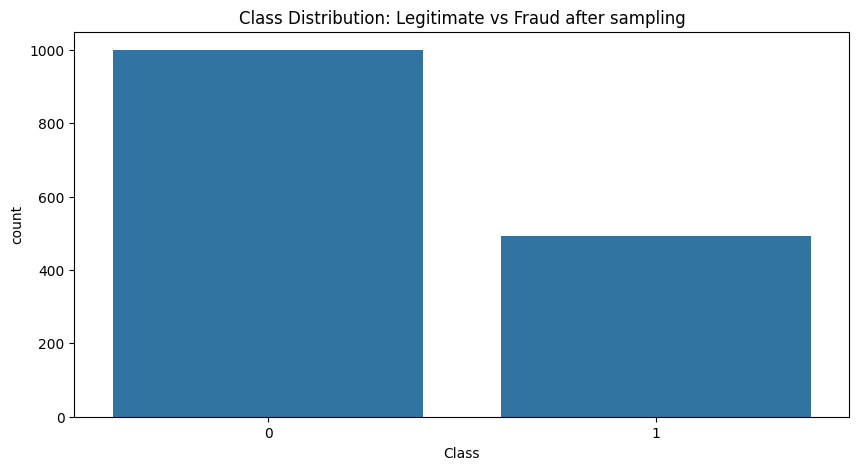

In [53]:
legit = data[data.Class == 0]
fraud = data[data.Class == 1]
legit_sample = legit.sample(n=1000, random_state=42)
data = pd.concat([legit_sample, fraud], axis=0)
plt.figure(figsize=(10, 5))
sns.countplot(x='Class', data=data)
plt.title('Class Distribution: Legitimate vs Fraud after sampling')
plt.show()
X = data.drop('Class', axis=1)
y = data['Class']

In [54]:
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()

### Train-Test split
We split the data in the ratio of 80% / 20% which is a standard choice for most of the machine learning models as it provides enough data for learning and enough data for testing

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

### Scaling the Data
StandardScaler normalizes the feature values, ensuring they have a mean of 0 and a standard deviation of 1

In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Selected Features:", selected_features)

Selected Features: ['V3', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']


## Building the Quantum Ciruit

**Note :** I have used 10 qubits here because as this model is run on a simulator and not a real quantum machine helps to regulate the training time. Also, because we have chosen 10 features from the 30 features, it helps to embed each feature as a qubit.

**Encoding :** I am using rotaitonal-y gate for encoding the features in the quantum state

**Layers** : I have used only 2 layers because our dataset after sampling is very small for any deep model. Also, the entanglement layer is used to bind all the data of the 10 qubits together so our result is not just based of one qubit though we expect a binary output.

In [67]:
num_qubits = 10
dev = qml.device('default.qubit', wires=num_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    for i in range(num_qubits):
        qml.RY(inputs[i], wires=i)

    for layer in range(2):
        for i in range(num_qubits):
            qml.RX(weights[layer][i][0], wires=i)
            qml.RZ(weights[layer][i][1], wires=i)

        # Entanglement
        for i in range(num_qubits-1):
            qml.CNOT(wires=[i, i+1])

    # Measuring in both X and Z bases
    return [qml.expval(qml.PauliX(i)) for i in range(num_qubits)] + [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

## Hybrid Quantum-Classical Model

The reason for choosing hybrid model is that after lot of efforts to make a purely quantum model I understood that the quantum advantage for this particular problem is less than 1 and hence its not feasible for quantum computing alone to beat the classical alternatives.

But, from my many tries I realized that though quantum ML alone can't beat classical ones, but the feature extraction of QML is very powerful due to extraction of realtions between columns through entanglement and superposition. This can help us improve the classical model in a very powerful way and get better insights  in the data.

**For demonstration perspective I have used Random-Forest Algorithm and its Quantum Hybrid.**

In [80]:
def generate_quantum_features(model, X):
    quantum_features = []
    for x in X:
        scaled_inputs = (x - np.min(x)) / (np.max(x) - np.min(x)) * 2 * np.pi
        quantum_output = quantum_circuit(scaled_inputs, np.random.uniform(0, 2*np.pi, (2, num_qubits, 2)))
        quantum_features.append(quantum_output)
    return np.array(quantum_features)

def quantumfit(model, X, y):
    quantum_features = generate_quantum_features(model, X)
    enhanced_features = np.hstack([X, quantum_features])
    model.fit(enhanced_features, y)

def qpredict(model, X):
    quantum_features = generate_quantum_features(model, X)
    enhanced_features = np.hstack([X, quantum_features])
    return model.predict(enhanced_features)

print("\nStarted training Hybrid Random Forest...")
hybrid_rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=-1)
quantumfit(hybrid_rf, X_train_scaled, y_train)
hybrid_pred = qpredict(hybrid_rf, X_test_scaled)
hybrid_accuracy = accuracy_score(y_test, hybrid_pred)
hybrid_precision = precision_score(y_test, hybrid_pred)
hybrid_recall = recall_score(y_test, hybrid_pred)
hybrid_f1 = f1_score(y_test, hybrid_pred)
hybrid_conf_matrix = confusion_matrix(y_test, hybrid_pred)

print(f"\nHybrid Random Forest Metrics:")
print(f"Accuracy: {hybrid_accuracy:.4f}")
print(f"Precision: {hybrid_precision:.4f}")
print(f"Recall: {hybrid_recall:.4f}")
print(f"F1 Score: {hybrid_f1:.4f}")
print("\nConfusion Matrix:")
print(hybrid_conf_matrix)


Started training Hybrid Random Forest...

Hybrid Random Forest Metrics:
Accuracy: 0.9632
Precision: 0.9889
Recall: 0.8990
F1 Score: 0.9418

Confusion Matrix:
[[199   1]
 [ 10  89]]


## Classical Random Forest for comparision

In [69]:
print("\nStarted training Classical Random Forest...")
classical_rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,  random_state=42, n_jobs=-1)
classical_rf.fit(X_train_scaled, y_train)
classical_pred = classical_rf.predict(X_test_scaled)
classical_accuracy = accuracy_score(y_test, classical_pred)
classical_precision = precision_score(y_test, classical_pred)
classical_recall = recall_score(y_test, classical_pred)
classical_f1 = f1_score(y_test, classical_pred)
classical_conf_matrix = confusion_matrix(y_test, classical_pred)

print(f"\nClassical Random Forest Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Started training Classical Random Forest...

Classical Random Forest Metrics:
Accuracy: 0.9599
Precision: 0.9677
Recall: 0.9091
F1 Score: 0.9375

Confusion Matrix:
[[197   3]
 [  9  90]]


## Comparision and Proof of Concept

In [81]:
print("\nImprovement Analysis:")
improvement = (hybrid_accuracy - classical_accuracy) * 100
print(f"Accuracy improvement: {improvement:.2f}%")
improvement = (hybrid_precision - classical_precision) * 100
print(f"\nPrecision improvement: {improvement:.2f}%")
improvement = (hybrid_recall - classical_recall) * 100
print(f"\nRecall improvement: {improvement:.2f}%")
improvement = (hybrid_f1 - classical_f1) * 100
print(f"\nF1 Score improvement: {improvement:.2f}%")


Improvement Analysis:
Accuracy improvement: 0.33%

Precision improvement: 2.11%

Recall improvement: -1.01%

F1 Score improvement: 0.43%


## Export the Quantum Random Forest Model

In [82]:
import joblib

# Save the trained model to a file
def export_model(model, filename):
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

# Example usage: Save the hybrid random forest model
export_model(hybrid_rf, "hybrid_random_forest_model.pkl")


Model saved to hybrid_random_forest_model.pkl
